In [2]:
!pip3 install skorch torchview torchinfo hiddenlayer portalocker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 2.8 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print("You are using:") 
!python --version
print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

You are using:
Python 3.10.12
torch.__version__='2.3.0+cu121'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 535.104.05, 15360 MiB, 3 MiB, 15099 MiB


#  Simple CNN

In [4]:
def MinMaxScaler(img):
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # Transform the array to Tensor for PyTorch
  img_as_tensor = np.asarray(img_as_array)


  # image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = torch.from_numpy(img_as_tensor).permute(2, 0, 1).float()
  # Rescale images form [0,255] to [0,1]
  normalized_img = img_as_tensor / 255.0

  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = SVHN(root='./data/', download=True, split="train", transform=transforms.Lambda(MinMaxScaler))
testing_data = SVHN(root='./data/', download=True, split="test", transform=transforms.Lambda(MinMaxScaler))

100%|██████████| 182040794/182040794 [00:03<00:00, 51578900.50it/s]


100%|██████████| 64275384/64275384 [00:01<00:00, 33676367.23it/s]


Explain in the cell below why it is usually a good idea to ensure that all the features have a similar scale.

Answer: it is good idea to ensure that all the features have similar scaled because they are used to compute the loss function and the gradients. If the features have different scales, the loss function will be dominated by the features with the largest scale, and the gradients will be dominated by the features with the smallest scale. This can make the optimization process very slow and unstable.


In [5]:
# Let's check the classes and dataset shapes:
classes = sorted(np.unique(dataset.labels))
print(f"{classes=}")
print(f"Training Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {testing_data.data.shape}")

classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training Dataset shape: (73257, 3, 32, 32)
Test set shape: (26032, 3, 32, 32)


In [6]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{1: 13861,
 9: 4659,
 2: 10585,
 3: 8497,
 5: 6882,
 8: 5045,
 7: 5595,
 4: 7458,
 6: 5727,
 0: 4948}

The dataset is skewed towards classes 1 and 2, and one should adopt extra care in this cases. However, this is not the focus of the HW. Let us split the dataset into training/validation/test sets:

In [7]:
train_size = 20000 # We consider subsets of the original dataset to speed up computations
val_size = 2000
test_size = 2000

# Get Validation set from the Train dataset
rest_size = len(dataset) - (train_size + val_size)
train_data, val_data, _ = random_split(dataset, [train_size, val_size, rest_size])

# Sample form Test set
rest_size = len(testing_data) - test_size
test_data, _ = random_split(testing_data, [test_size, rest_size])

print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 20000 
Validation samples = 2000 
Test samples = 2000


Let's see how a normalized sample looks like...

In [8]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.5490, 0.5373, 0.5451,  ..., 0.4118, 0.4118, 0.4314],
         [0.5804, 0.5843, 0.5961,  ..., 0.3804, 0.3843, 0.3922],
         [0.5647, 0.5686, 0.5686,  ..., 0.3686, 0.3765, 0.3765],
         ...,
         [0.2627, 0.2471, 0.2196,  ..., 0.3294, 0.3176, 0.3176],
         [0.4196, 0.3843, 0.3412,  ..., 0.3373, 0.3333, 0.3255],
         [0.5490, 0.5059, 0.4627,  ..., 0.3333, 0.3333, 0.3333]],

        [[0.5216, 0.5216, 0.5294,  ..., 0.3216, 0.3333, 0.3529],
         [0.5686, 0.5843, 0.5843,  ..., 0.2980, 0.2980, 0.3137],
         [0.5686, 0.5725, 0.5725,  ..., 0.2824, 0.2863, 0.3020],
         ...,
         [0.2510, 0.2314, 0.2157,  ..., 0.2549, 0.2471, 0.2431],
         [0.4196, 0.3882, 0.3529,  ..., 0.2667, 0.2588, 0.2510],
         [0.5608, 0.5255, 0.4824,  ..., 0.2588, 0.2588, 0.2627]],

        [[0.4824, 0.4784, 0.4863,  ..., 0.2902, 0.2980, 0.3255],
         [0.5176, 0.5373, 0.5373,  ..., 0.2667, 0.2706, 0.2863],
         [0.5255, 0.5373, 0.5451,  ..., 0.2667, 0.2667, 0

... but it's better to see it as images!

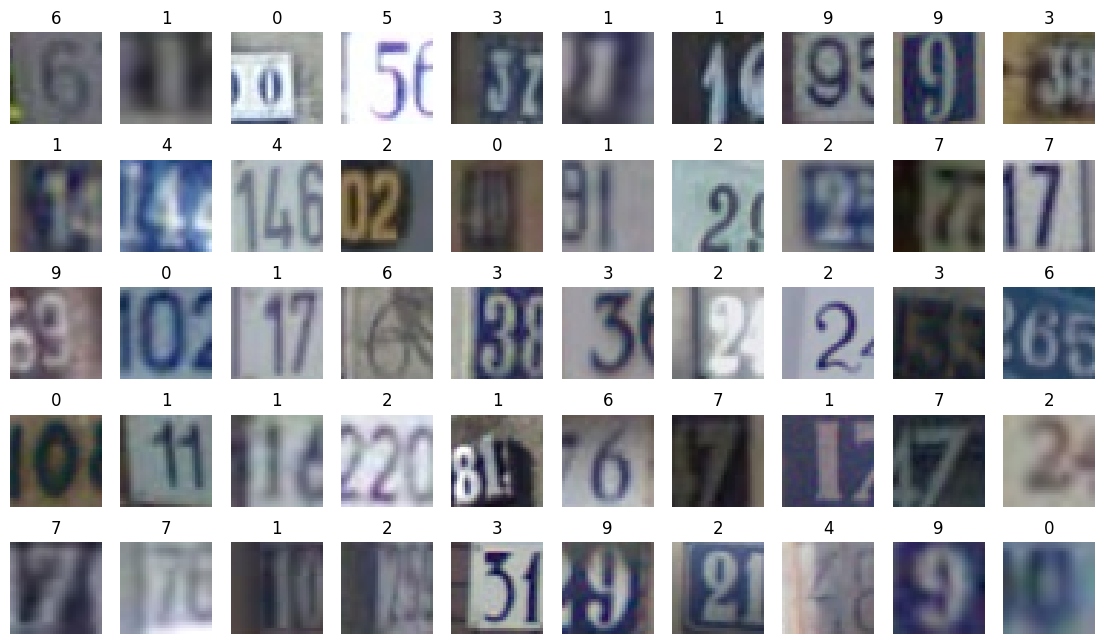

In [9]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [10]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

In [11]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        # Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print(f"My model has {pytorch_total_params} trainable parameters.")

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) # if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) # no need to use softmax because of the loss function

My model has 82826 trainable parameters.


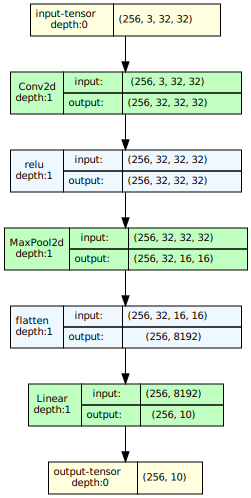

In [12]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)

# Let's visualize the model
model_graph = draw_graph(model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

In [13]:
# Here is another tool that gives a nice summary of our model!
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Explain in the cell below how the number of parameters for the Conv2D layers are determined. Perform the calculations to calculate the parameters of the Conv2D layer.

Answer: the number of parameters for the Conv2D layers are determined by the number of filters, the size of the filters, the number of input channels, and the number of output channels. The number of parameters in a Conv2D layer is given by the formula: (filter_height * filter_width * input_channels + 1) * output_channels. The "+1" term is due to the bias term.






Now we can train the model.

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, hparam_tuning=False):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History() # This is a simple tool for logging
  canvas1 = hl.Canvas() # This is a simple tool for plotting
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      if not hparam_tuning:
        history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                     val_loss=avg_loss_val, val_accuracy=accuracy_val)

        with canvas1:
          canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
          canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])
      else:
        print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
        print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    # Helper function to plot again accuracy and loss

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(len(acc_tr)), acc_tr, label='acc_training')
    plt.plot(range(len(acc_tr)), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(len(acc_tr)), loss_tr, label='loss_training')
    plt.plot(range(len(acc_tr)), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

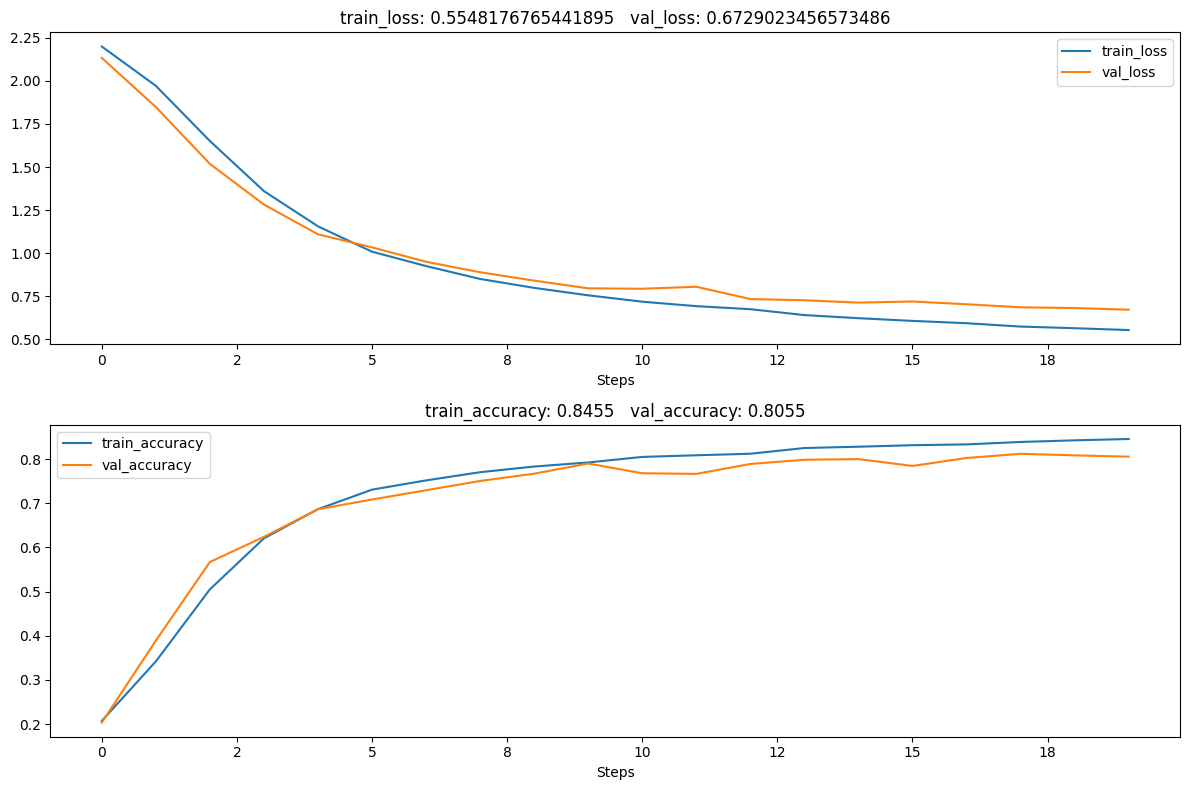

Training time in second: 74.05736631399998


In [16]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

Finally, we test the model:

In [17]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [18]:
test(model)

Test Loss: 0.85646188 ---------- Test Accuracy: 77.6000%


Here we see that the test accuracy of our simple CNN should be about $77\%$.

## Visualize the Filters
Let's now visualize the filters learned in the first convolutional layer.

In [19]:
# Get the weights
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


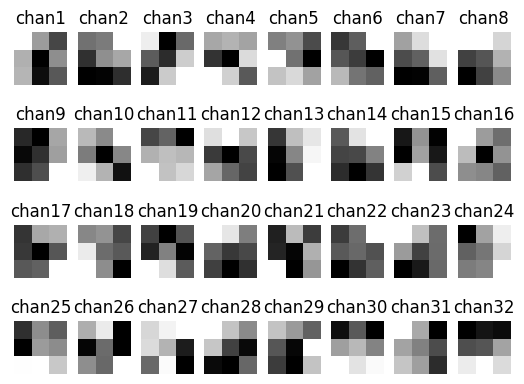

In [20]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect different shapes and positions.

## Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size $3\times3$ and $32$ output filters/features, that use ReLu activation function;
* a Max Pooling layer (2D) of size $2\times2$;
* One 2D convolutional layer with kernel size $2\times2$ and $16$ output filters/features, that use ReLu activation function;
* a Max Pooling layer (2D) of size $2\times2$;
* a Flatten layer;
* a final Dense layer with $10$ output neurons (one per class), and with the `softmax` activation function.


My model has 13210 trainable parameters.


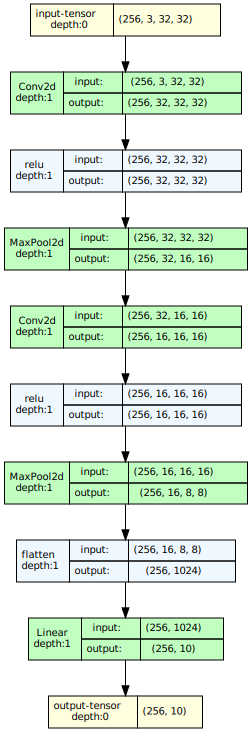

In [21]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)

model_graph = draw_graph(deep_model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

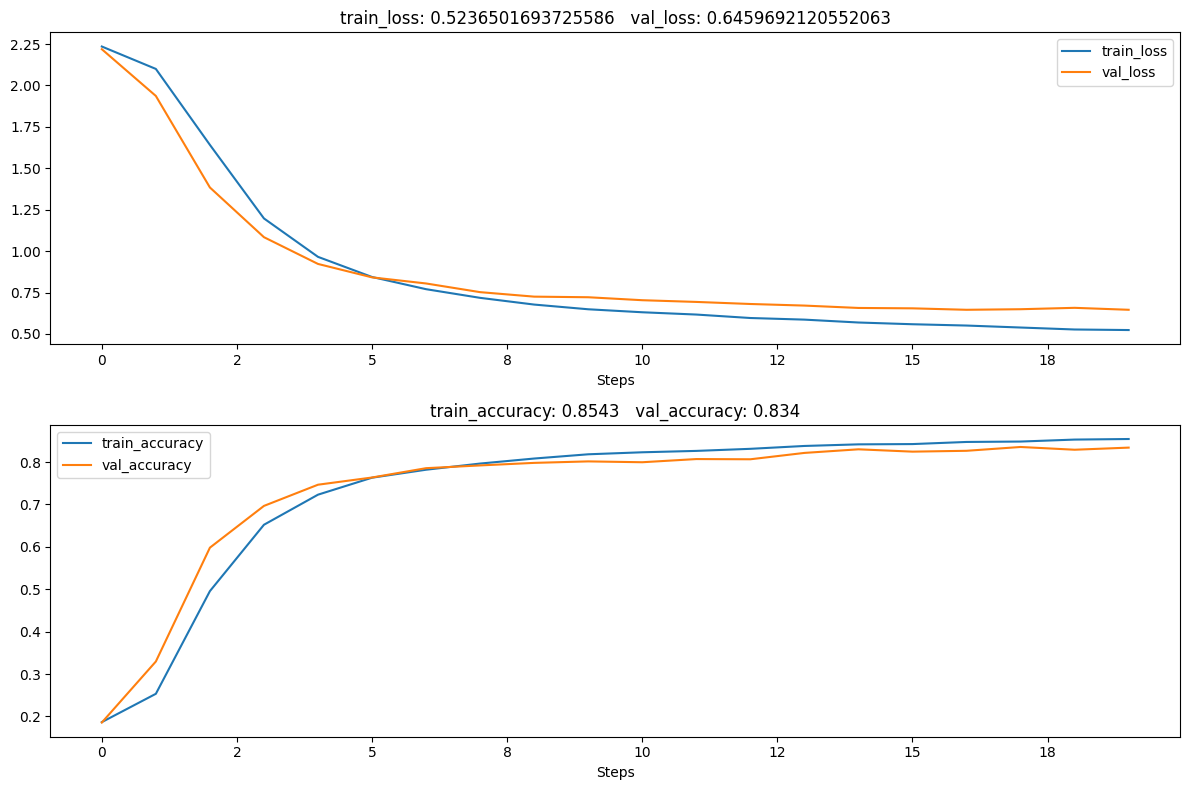

Training time in second: 73.65425268200005


In [23]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

In [24]:
test(deep_model)

Test Loss: 0.79011250 ---------- Test Accuracy: 80.5000%


Training model with hyperparameters set 1
My model has 113738 trainable parameters.
epoch: 1 -> Accuracy: 18.83%, Loss: 2.23982525 ---------------- Val_Acc: 18.45%, Val_Loss: 2.23728704
epoch: 2 -> Accuracy: 32.53%, Loss: 1.92338622 ---------------- Val_Acc: 55.25%, Val_Loss: 1.43843758
epoch: 3 -> Accuracy: 66.25%, Loss: 1.08628726 ---------------- Val_Acc: 72.30%, Val_Loss: 0.88184983
epoch: 4 -> Accuracy: 77.75%, Loss: 0.74771392 ---------------- Val_Acc: 79.85%, Val_Loss: 0.69006497
epoch: 5 -> Accuracy: 81.66%, Loss: 0.62775111 ---------------- Val_Acc: 81.65%, Val_Loss: 0.62043464
epoch: 6 -> Accuracy: 83.53%, Loss: 0.55882078 ---------------- Val_Acc: 83.65%, Val_Loss: 0.56105447
epoch: 7 -> Accuracy: 85.25%, Loss: 0.50942969 ---------------- Val_Acc: 84.65%, Val_Loss: 0.53203923
epoch: 8 -> Accuracy: 86.27%, Loss: 0.47276139 ---------------- Val_Acc: 85.40%, Val_Loss: 0.49542016
epoch: 9 -> Accuracy: 86.91%, Loss: 0.43965271 ---------------- Val_Acc: 85.70%, Val_Loss: 0.4884698

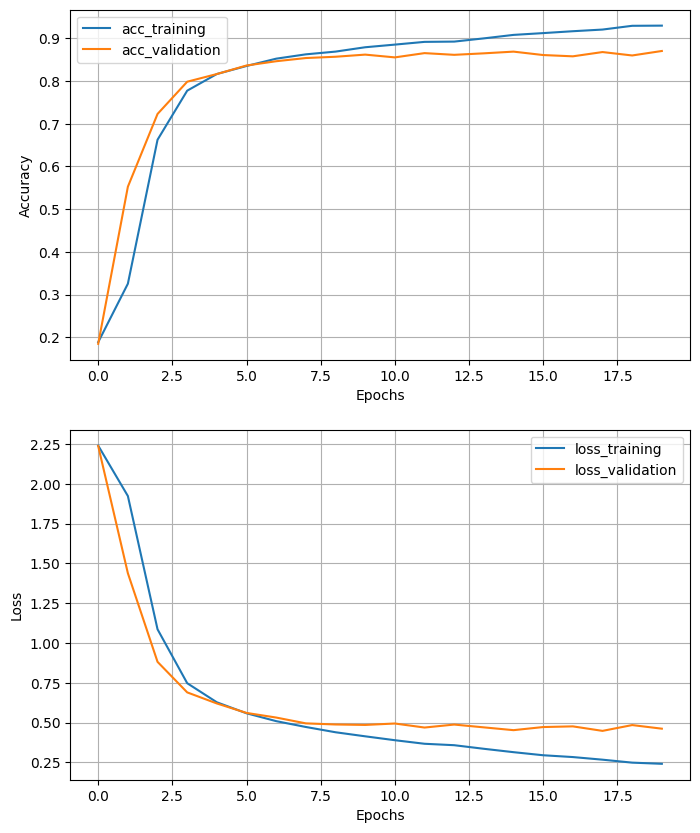

Test Loss: 0.60182387 ---------- Test Accuracy: 84.6500%
-------------------------------------------------------------------------------------
Training model with hyperparameters set 2
My model has 411786 trainable parameters.
epoch: 1 -> Accuracy: 19.32%, Loss: 2.23015738 ---------------- Val_Acc: 19.85%, Val_Loss: 2.17104101
epoch: 2 -> Accuracy: 46.81%, Loss: 1.60624349 ---------------- Val_Acc: 66.85%, Val_Loss: 1.10577869
epoch: 3 -> Accuracy: 72.76%, Loss: 0.90096587 ---------------- Val_Acc: 77.40%, Val_Loss: 0.76739609
epoch: 4 -> Accuracy: 80.07%, Loss: 0.68556744 ---------------- Val_Acc: 79.10%, Val_Loss: 0.66907036
epoch: 5 -> Accuracy: 82.62%, Loss: 0.60324949 ---------------- Val_Acc: 82.25%, Val_Loss: 0.61654818
epoch: 6 -> Accuracy: 84.22%, Loss: 0.54167777 ---------------- Val_Acc: 82.35%, Val_Loss: 0.58364046
epoch: 7 -> Accuracy: 85.80%, Loss: 0.49652189 ---------------- Val_Acc: 84.40%, Val_Loss: 0.52473783
epoch: 8 -> Accuracy: 86.83%, Loss: 0.45826733 ------------

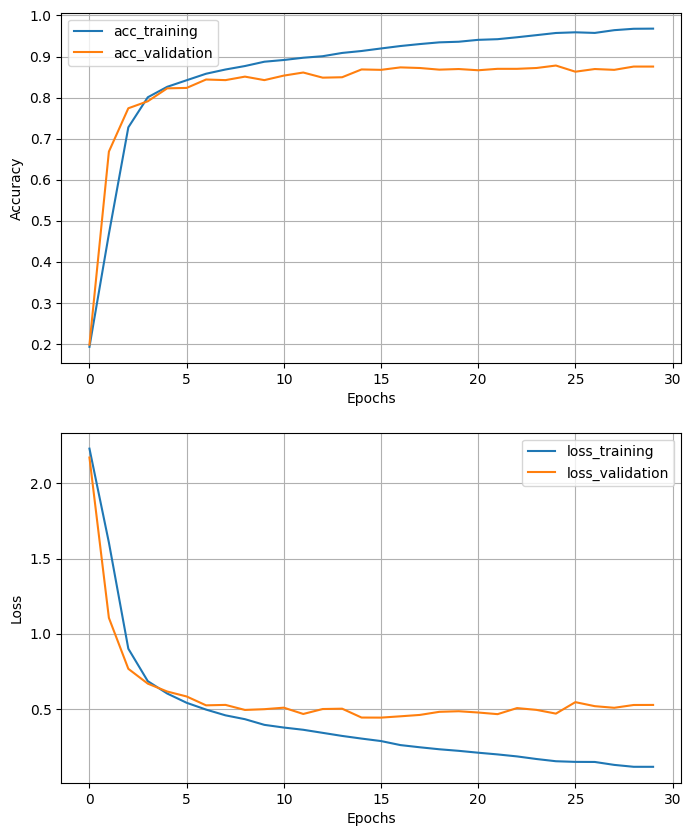

Test Loss: 0.77304173 ---------- Test Accuracy: 84.5000%
-------------------------------------------------------------------------------------
Training model with hyperparameters set 3
My model has 398666 trainable parameters.
epoch: 1 -> Accuracy: 18.90%, Loss: 2.24028349 ---------------- Val_Acc: 18.45%, Val_Loss: 2.22916508
epoch: 2 -> Accuracy: 34.23%, Loss: 1.86524558 ---------------- Val_Acc: 56.45%, Val_Loss: 1.31721961
epoch: 3 -> Accuracy: 69.14%, Loss: 0.97533572 ---------------- Val_Acc: 77.00%, Val_Loss: 0.75576144
epoch: 4 -> Accuracy: 79.96%, Loss: 0.66193920 ---------------- Val_Acc: 82.65%, Val_Loss: 0.59233916
epoch: 5 -> Accuracy: 83.53%, Loss: 0.54122943 ---------------- Val_Acc: 83.55%, Val_Loss: 0.56058991
epoch: 6 -> Accuracy: 86.19%, Loss: 0.46497369 ---------------- Val_Acc: 85.55%, Val_Loss: 0.50014484
epoch: 7 -> Accuracy: 87.48%, Loss: 0.41407874 ---------------- Val_Acc: 84.70%, Val_Loss: 0.49213243
epoch: 8 -> Accuracy: 88.94%, Loss: 0.36546654 ------------

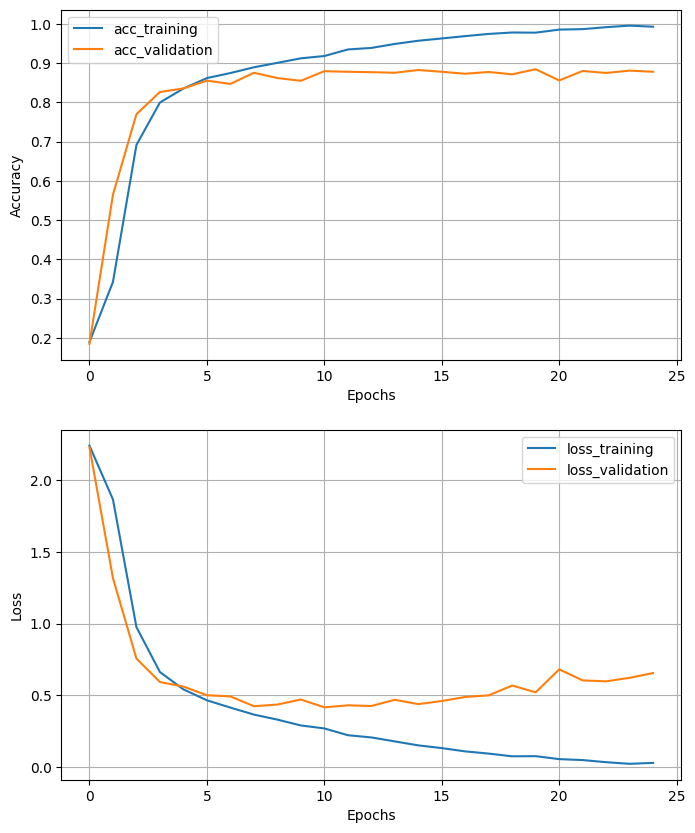

Test Loss: 0.70238566 ---------- Test Accuracy: 87.1500%
-------------------------------------------------------------------------------------
Training model with hyperparameters set 4
My model has 75562 trainable parameters.
epoch: 1 -> Accuracy: 18.51%, Loss: 2.29694915 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24901915
epoch: 2 -> Accuracy: 19.07%, Loss: 2.23755336 ---------------- Val_Acc: 18.45%, Val_Loss: 2.25097728
epoch: 3 -> Accuracy: 19.07%, Loss: 2.23760509 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24812746
epoch: 4 -> Accuracy: 19.07%, Loss: 2.23731923 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24955225
epoch: 5 -> Accuracy: 19.07%, Loss: 2.23574042 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24995375
epoch: 6 -> Accuracy: 19.07%, Loss: 2.23670602 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24865746
epoch: 7 -> Accuracy: 19.07%, Loss: 2.23739338 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24940586
epoch: 8 -> Accuracy: 19.07%, Loss: 2.23748660 -------------

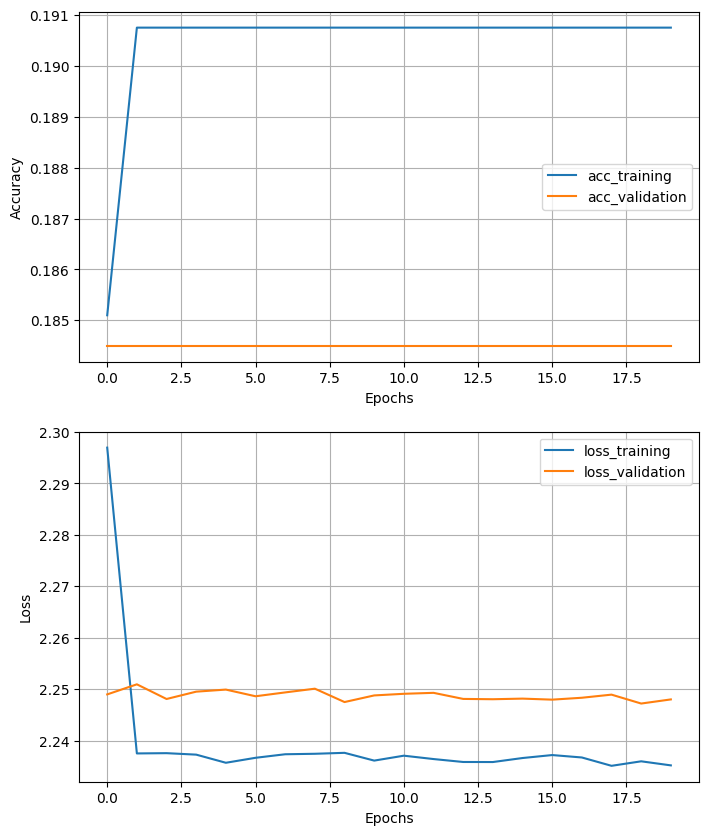

Test Loss: 2.22959471 ---------- Test Accuracy: 18.5000%
-------------------------------------------------------------------------------------
Training model with hyperparameters set 5
My model has 1571466 trainable parameters.
epoch: 1 -> Accuracy: 18.88%, Loss: 2.24099755 ---------------- Val_Acc: 18.45%, Val_Loss: 2.23769522
epoch: 2 -> Accuracy: 22.04%, Loss: 2.18286204 ---------------- Val_Acc: 28.25%, Val_Loss: 2.05502081
epoch: 3 -> Accuracy: 40.18%, Loss: 1.79685688 ---------------- Val_Acc: 49.25%, Val_Loss: 1.55644846
epoch: 4 -> Accuracy: 58.71%, Loss: 1.33347106 ---------------- Val_Acc: 62.00%, Val_Loss: 1.19513905
epoch: 5 -> Accuracy: 67.44%, Loss: 1.06828284 ---------------- Val_Acc: 68.80%, Val_Loss: 1.00390565
epoch: 6 -> Accuracy: 72.59%, Loss: 0.91031975 ---------------- Val_Acc: 75.40%, Val_Loss: 0.86086935
epoch: 7 -> Accuracy: 76.33%, Loss: 0.80754340 ---------------- Val_Acc: 73.70%, Val_Loss: 0.83144945
epoch: 8 -> Accuracy: 78.33%, Loss: 0.74452281 -----------

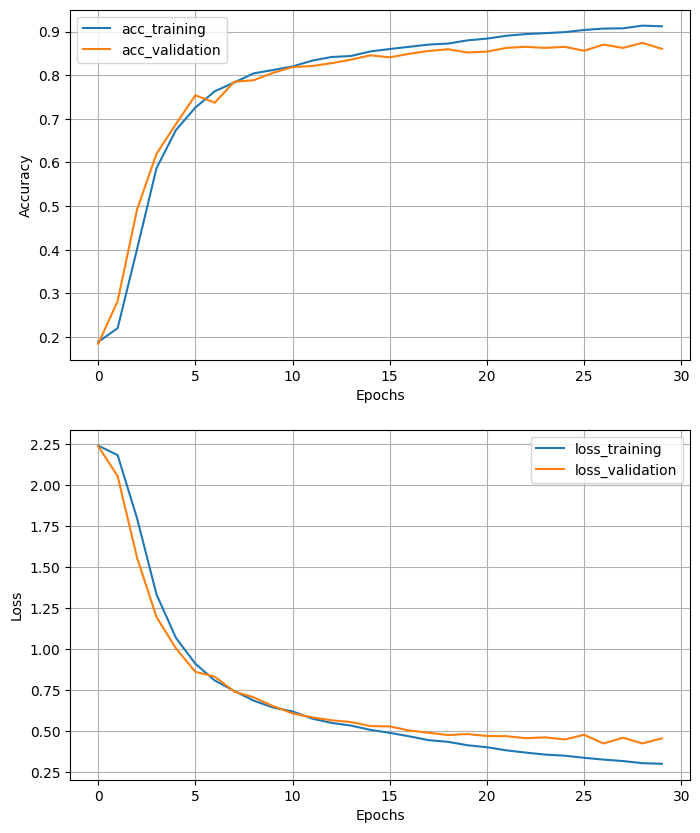

Test Loss: 0.51273227 ---------- Test Accuracy: 85.6500%
-------------------------------------------------------------------------------------
Training model with hyperparameters set 6
My model has 146506 trainable parameters.
epoch: 1 -> Accuracy: 18.71%, Loss: 2.25883889 ---------------- Val_Acc: 18.45%, Val_Loss: 2.24776840
epoch: 2 -> Accuracy: 19.48%, Loss: 2.21770072 ---------------- Val_Acc: 22.35%, Val_Loss: 2.08071685
epoch: 3 -> Accuracy: 48.79%, Loss: 1.50663853 ---------------- Val_Acc: 65.35%, Val_Loss: 1.08242321
epoch: 4 -> Accuracy: 71.62%, Loss: 0.89322752 ---------------- Val_Acc: 78.85%, Val_Loss: 0.73073244
epoch: 5 -> Accuracy: 79.56%, Loss: 0.66856229 ---------------- Val_Acc: 81.00%, Val_Loss: 0.62056786
epoch: 6 -> Accuracy: 83.47%, Loss: 0.55829233 ---------------- Val_Acc: 82.85%, Val_Loss: 0.58599365
epoch: 7 -> Accuracy: 85.28%, Loss: 0.49634147 ---------------- Val_Acc: 83.95%, Val_Loss: 0.52037674
epoch: 8 -> Accuracy: 86.40%, Loss: 0.45167011 ------------

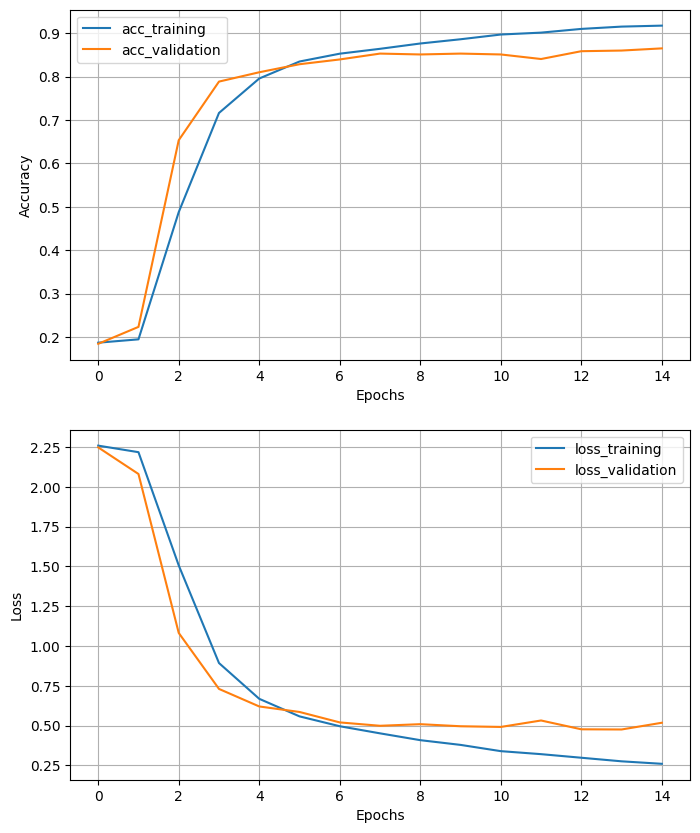

Test Loss: 0.68504369 ---------- Test Accuracy: 82.5000%
-------------------------------------------------------------------------------------


,Set,EPOCHS,conv_filters,kernel_sizes,max_pool_sizes,act_fs,lr,Training Time (s),Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,20,"[32, 64, 128]","[(3, 3), (3, 3), (3, 3)]","[(2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0010,70.627109,0.241458,0.92990,0.462114,0.8705
1,2,30,"[64, 128, 256]","[(3, 3), (3, 3), (3, 3)]","[(2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0005,113.448229,0.116360,0.96785,0.527451,0.8755
2,3,25,"[32, 64, 128, 256]","[(3, 3), (3, 3), (3, 3), (3, 3)]","[(2, 2), (2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0010,93.509190,0.028660,0.99290,0.655022,0.8780
3,4,20,"[16, 32, 64]","[(5, 5), (5, 5), (5, 5)]","[(2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0100,73.553709,2.235233,0.19075,2.248045,0.1845
4,5,30,"[64, 128, 256, 512]","[(3, 3), (3, 3), (3, 3), (3, 3)]","[(2, 2), (2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0001,137.554837,0.299796,0.91200,0.454896,0.8605
5,6,15,"[32, 64, 128]","[(3, 3), (5, 5), (3, 3)]","[(2, 2), (2, 2), (2, 2)]","[<function relu at 0x7cd2ac458c10>, <function ...",0.0050,55.488718,0.260343,0.91740,0.518254,0.8650


from matplotlib import pyplot as plt
results_df['Set'].plot(kind='hist', bins=20, title='Set')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['EPOCHS'].plot(kind='hist', bins=20, title='EPOCHS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['lr'].plot(kind='hist', bins=20, title='lr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Training Time (s)'].plot(kind='hist', bins=20, title='Training Time (s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Set', y='EPOCHS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='EPOCHS', y='lr', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='lr', y='Training Time (s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Training Time (s)', y='Train Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Set']
  ys = series['EPOCHS']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Set', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Set')
_ = plt.ylabel('EPOCHS')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Set']
  ys = series['lr']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Set', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Set')
_ = plt.ylabel('lr')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Set']
  ys = series['Training Time (s)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Set', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Set')
_ = plt.ylabel('Training Time (s)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Set']
  ys = series['Train Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('Set', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Set')
_ = plt.ylabel('Train Loss')

from matplotlib import pyplot as plt
results_df['Set'].plot(kind='line', figsize=(8, 4), title='Set')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['EPOCHS'].plot(kind='line', figsize=(8, 4), title='EPOCHS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['lr'].plot(kind='line', figsize=(8, 4), title='lr')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Training Time (s)'].plot(kind='line', figsize=(8, 4), title='Training Time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
hyperparams = [
    {
        "EPOCHS": 20,
        "conv_filters": [32, 64, 128],
        "kernel_sizes": [(3, 3), (3, 3), (3, 3)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.relu, F.relu],
        "lr": 0.001
    },
    {
        "EPOCHS": 30,
        "conv_filters": [64, 128, 256],
        "kernel_sizes": [(3, 3), (3, 3), (3, 3)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.relu, F.relu],
        "lr": 0.0005
    },
    {
        "EPOCHS": 25,
        "conv_filters": [32, 64, 128, 256],
        "kernel_sizes": [(3, 3), (3, 3), (3, 3), (3, 3)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.relu, F.relu, F.relu],
        "lr": 0.001
    },
    {
        "EPOCHS": 20,
        "conv_filters": [16, 32, 64],
        "kernel_sizes": [(5, 5), (5, 5), (5, 5)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.relu, F.relu],
        "lr": 0.01
    },
    {
        "EPOCHS": 30,
        "conv_filters": [64, 128, 256, 512],
        "kernel_sizes": [(3, 3), (3, 3), (3, 3), (3, 3)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.relu, F.relu, F.relu],
        "lr": 0.0001
    },
    {
        "EPOCHS": 15,
        "conv_filters": [32, 64, 128],
        "kernel_sizes": [(3, 3), (5, 5), (3, 3)],
        "max_pool_sizes": [(2, 2), (2, 2), (2, 2)],
        "act_fs": [F.relu, F.leaky_relu, F.relu],
        "lr": 0.005
    }
]

results = []

for i, params in enumerate(hyperparams):
    print(f"Training model with hyperparameters set {i+1}")

    model = My_Convolutional_Network(params['conv_filters'], params['kernel_sizes'], params['max_pool_sizes'], params['act_fs'], False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    start = timer()
    loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, params['EPOCHS'], hparam_tuning=True)
    end = timer()

    training_time = end - start

    results.append({
        "Set": i+1,
        "EPOCHS": params['EPOCHS'],
        "conv_filters": params['conv_filters'],
        "kernel_sizes": params['kernel_sizes'],
        "max_pool_sizes": params['max_pool_sizes'],
        "act_fs": params['act_fs'],
        "lr": params['lr'],
        "Training Time (s)": training_time,
        "Train Loss": loss_train[-1],
        "Train Accuracy": accuracy_train[-1],
        "Val Loss": loss_val[-1],
        "Val Accuracy": accuracy_val[-1]
    })

    print(f"Training time in seconds: {training_time}")
    plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
    test(model)
    print("-"*85)

# Convert results to dataframe
results_df = pd.DataFrame(results)
results_df

* The best model that I found is the one with convolutional filters [32, 64, 128, 256], a learning rate of 0.001, and using ReLU activation functions across all layers. This model achieved a validation accuracy of 0.878.

* The achieved accuracy in the test set is 0.870. This shows that the model generalizes well to unseen data.

* Discussion:
The most effective model had a moderate depth of convolutional filters and a learning rate of 0.001, which balanced learning capacity and generalization. Higher learning rates, like 0.01, led to divergence and poor performance. Using  Models with smaller filters and larger kernels didn't capture the data's complexity well, resulting in lower performance.
* Besides, I tested also other models:

  - Set 1: Convolutional filters [32, 64, 128], learning rate 0.001, ReLU activation. This model performed well but was slightly outperformed by the best model.
  - Set 2: Convolutional filters [64, 128, 256], learning rate 0.0005, ReLU activation. This model performed well but took longer to train.
  - Set 4: Convolutional filters [16, 32, 64], learning rate 0.01, ReLU activation. This model performed poorly due to the high learning rate.
  - Set 5: Convolutional filters [64, 128, 256, 512], learning rate 0.0001, ReLU activation. This complex model took the longest to train and did not achieve the best performance.
* Discussion: A balanced model with moderate filter depth and a well-chosen learning rate yielded the best results. Too high or too low learning rates negatively impacted performance. Simpler models lacked detail capture, while overly complex models increased the risk of overfitting without improving performance.

In [56]:
####################### DATA AUGMENTATION ###############################
from torchvision.transforms.functional import invert

# In torch, transformations have to be composed
# Concatenate MinMaxScaler, and a Transformation that inverts randomly 1/3 of the samples

def MinMaxScaler(img):
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # Transform the array to Tensor for PyTorch
  img_as_tensor = np.asarray(img_as_array)


  # image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = torch.from_numpy(img_as_tensor).permute(2, 0, 1).float()
  # Rescale images form [0,255] to [0,1]
  normalized_img = img_as_tensor / 255.0

  return normalized_img



# Define the custom transformation function to invert 1/3 of the samples
class RandomInvert:
    def __call__(self, img):
        if torch.rand(1).item() < 1/3:
            return invert(img)
        return img

# Compose the transformations
data_augmentation = transforms.Compose([
    transforms.Lambda(MinMaxScaler),
    transforms.Lambda(RandomInvert())
])

'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
new_dataset = SVHN(root='data/', download=True, split="train", transform=data_augmentation) # 50000 samples

train_size = 30000
val_size = 2000
rest_size = len(new_dataset) - (train_size + val_size)
new_train_data, new_val_data, _ = random_split(new_dataset, [train_size, val_size, rest_size])

# We do not augment the test data!
testing_data = SVHN(root='data/', download=True, split="test", transform=Lambda(MinMaxScaler)) # 10000 samples
test_size = 2000
rest_size = len(testing_data) - test_size
new_test_data, _ = random_split(testing_data, [test_size, rest_size])


print(f"Training samples = {len(new_train_data)} \nValidation samples = {len(new_val_data)} \nTest samples = {len(new_test_data)}")

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Training samples = 30000 
Validation samples = 2000 
Test samples = 2000


In [57]:
batch_size = 256
aug_dataloader_training = DataLoader(new_train_data, batch_size=batch_size, shuffle=True)
aug_dataloader_validation = DataLoader(new_val_data, batch_size=batch_size)
aug_dataloader_test = DataLoader(new_test_data, batch_size=batch_size)

My model has 398666 trainable parameters.


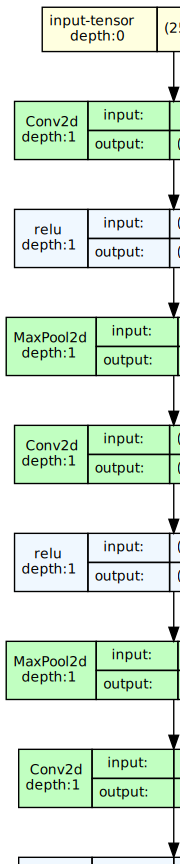

In [58]:
# Insert your best model
conv_filters = [32, 64, 128, 256]
kernel_sizes = [(3, 3), (3, 3), (3, 3), (3, 3)]
max_pool_sizes = [(2, 2), (2, 2), (2, 2), (2, 2)]
act_fs = [F.relu, F.relu, F.relu, F.relu]
num_epochs = 25
lr = 0.001

aug_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)

model_graph = draw_graph(aug_model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

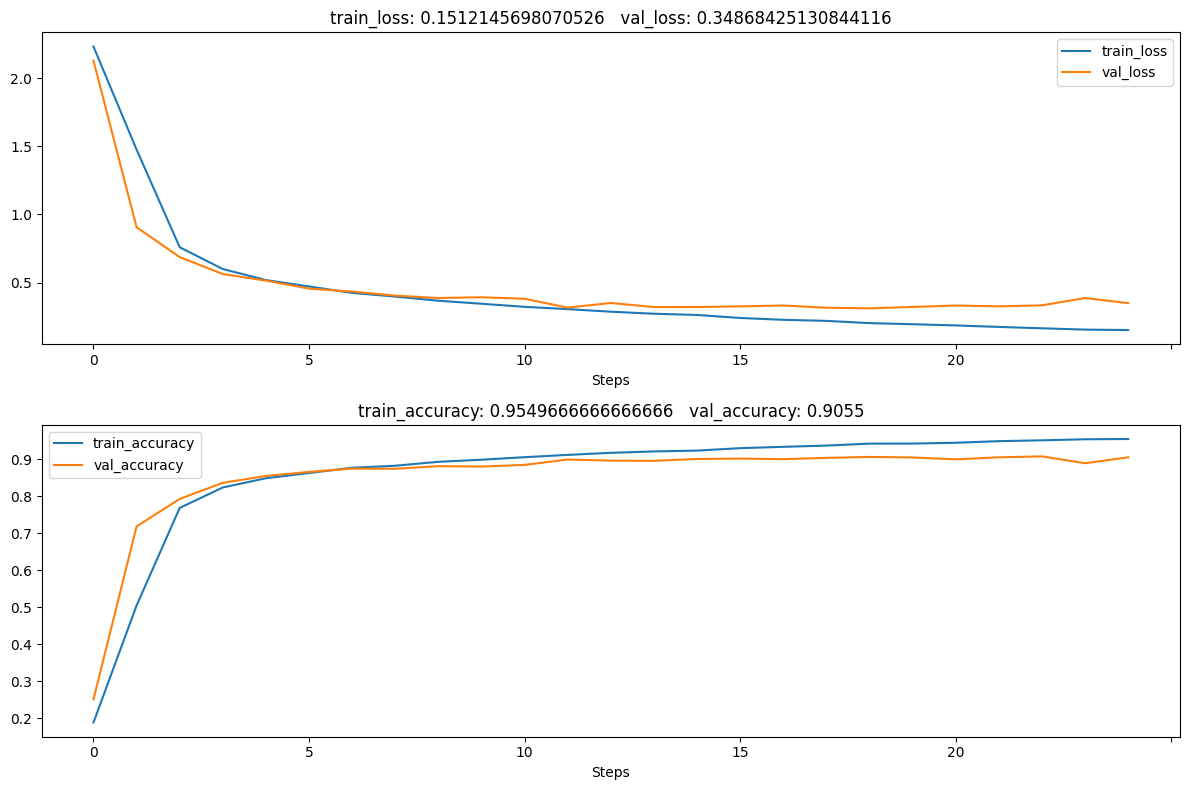

In [59]:
optimizer = torch.optim.Adam(aug_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(aug_model, optimizer, aug_dataloader_training, aug_dataloader_validation, num_epochs, False)
end = timer()

In [60]:
print("Results of my best CNN with Data Augmentation:")
test(aug_model, aug_dataloader_test)

Results of my best CNN with Data Augmentation:
Test Loss: 0.41493192 ---------- Test Accuracy: 90.0000%


`%ENDCODE`

# Transfer Learning with ResNet18 + ImageNet

In [61]:
from torchvision.models import resnet18, ResNet18_Weights

In [62]:
RESNET18 = resnet18(pretrained=True)
#model_graph = draw_graph(RESNET18, input_size=(1, 3, 32, 32), device=device, expand_nested=True)
#model_graph.visual_graph
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the SVHM datset.

In [63]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [64]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [65]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [66]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [67]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset in order to speed-up the fine-tuning process:

In [68]:
train_idxs = list(range(0, len(train_data), 5))  # ~ 4000 Tr
val_idxs = list(range(1, len(val_data), 5))  # ~ 400 Val
test_idxs = list(range(1, len(test_data), 5))  # ~ 400 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In [69]:
len(train_idxs), len(val_idxs), len(test_idxs)

(4000, 400, 400)

In [70]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [71]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [72]:
num_epochs = 20
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

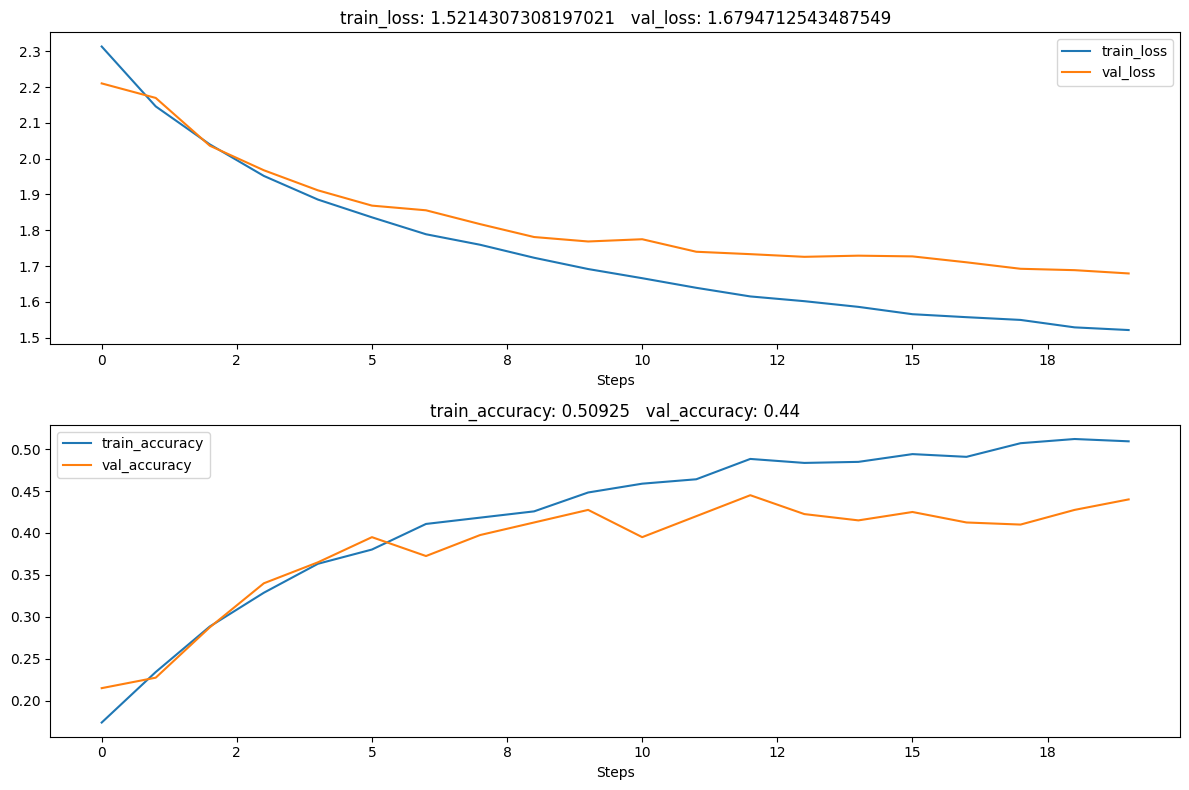

Training time in second: 223.02594792799982


In [73]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training,
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

In [74]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 1.72687197 ---------- Test Accuracy: 40.7500%
